##### Load Data

In [1]:
from bs4                     import BeautifulSoup
import matplotlib.pyplot     as plt
import matplotlib.image      as mpimg
import numpy                 as np
import skimage.transform
import dicom
import glob
import model
import scipy.misc
import os
import h5py
import json
import pylab

data_filepath = "/enc_data/eddata/pacemaker/"
ann_filepath = data_filepath + "ann/"
img_filepath = data_filepath + 'organized-data/'
png_filepath = data_filepath + 'png/'

SIZE_X = 726
SIZE_Y = 726
VGG_DIMS = (224, 224)

Using TensorFlow backend.


In [2]:
def load_data():
    def resize(image):
        """ Resizes the image into dimensions specified by dims and converts img to 3 channels """
        newimg = skimage.transform.resize(image, VGG_DIMS)

        # Convert from 1 channel to 3 channels
        newimg_3d = np.empty(VGG_DIMS + (3,))
        for i in range(3):
            newimg_3d[:,:,i] = newimg

        return newimg_3d

    def load_images(path, number):
        """ Path: Path to .png images
            Number: Number of images to run
            Dims: (height, width) of the final images that will be fed into the model """

        return np.array([ resize(plt.imread(path + image_path)) for image_path in os.listdir(path)[:number] ])
    
    pos_imgs = load_images(png_filepath + "pacemaker/max_size/", number=300)
    neg_imgs = load_images(png_filepath + "neg/", number=300)
    
    X = np.concatenate((pos_imgs, neg_imgs))
    Y = np.array([1] * pos_imgs.shape[0] + [0] * neg_imgs.shape[0])
    print X.shape, Y.shape
    return X, Y

In [3]:
X, Y = load_data()

/home/alyssayc/.virtualenvs/venv/local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(600, 224, 224, 3) (600,)


##### Model

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from sklearn.model_selection         import train_test_split
from keras.applications.vgg16        import VGG16
from keras.applications.inception_v3        import InceptionV3


from keras.preprocessing.image       import ImageDataGenerator
from keras.models                    import Sequential, Model, Input
from keras.layers                    import Dense, Flatten, Dropout
from keras.optimizers                import SGD, RMSprop, Adam
from keras.callbacks                 import EarlyStopping
from keras.utils                     import np_utils
from keras                           import backend as K

In [5]:
# Split into test and train/validation set
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.6, random_state=42, stratify=Y)
print('Train shape: ', X_train.shape, y_train.shape)
print('Test shape: ', X_test.shape, np.array(y_test).shape)

/home/alyssayc/.virtualenvs/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


('Train shape: ', (360, 224, 224, 3), (360,))
('Test shape: ', (240, 224, 224, 3), (240,))


In [6]:
# Categorize the labels
num_classes = 2
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
print("y_train,y_test: ", y_train.shape,y_test.shape)

('y_train,y_test: ', (360, 2), (240, 2))


In [7]:
# Create the base pre-trained model
base_model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

x = base_model.output
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# k = 1 # number of end layers to retrain
# layers = base_model.layers[:-k] if k != 0 else base_model.layers
# for layer in layers: 
#     layer.trainable = False
# #print(model.summary())

In [10]:
opt = SGD(lr=0.0001, momentum=0.9)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=["accuracy"])
history = model.fit(x=X_train, y=y_train, epochs=30, validation_split=0.5)

Train on 180 samples, validate on 180 samples
Epoch 1/30
180/180 [==============================] - 7s 38ms/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.1759 - val_acc: 0.9278
Epoch 2/30
180/180 [==============================] - 2s 9ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.1612 - val_acc: 0.9389
Epoch 3/30
180/180 [==============================] - 2s 9ms/step - loss: 0.0156 - acc: 1.0000 - val_loss: 0.1506 - val_acc: 0.9389
Epoch 4/30
180/180 [==============================] - 2s 9ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.1408 - val_acc: 0.9444
Epoch 5/30
180/180 [==============================] - 2s 9ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.1385 - val_acc: 0.9389
Epoch 6/30
180/180 [==============================] - 2s 9ms/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.1317 - val_acc: 0.9389
Epoch 7/30
180/180 [==============================] - 2s 9ms/step - loss: 0.0112 - acc: 1.0000 - val_loss: 0.1258 - val_acc: 0.9444
Epoch 8/30
180/180 [=========

In [11]:
test_loss, accuracy = model.evaluate(x=X_test, y=y_test, verbose=1)
print(accuracy)

240/240 [==============================] - 1s 3ms/step
0.991666666667


In [17]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

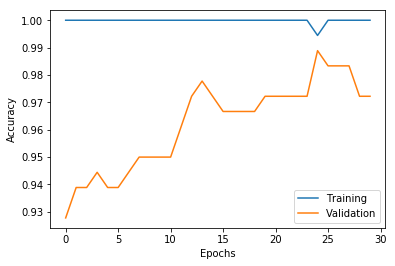

In [26]:
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [27]:
model_filename = 'inception_patches.h5'
model.save(model_filename)

#### Get patches from full image

In [28]:
imgspath = "/enc_data/eddata/pacemaker/png/full_image"

In [93]:
def convert_to_3d(patch):
    # Convert from 1 channel to 3 channels
    newimg = np.empty(VGG_DIMS + (3,))
    for i in range(3):
        newimg[:,:,i] = patch
    return newimg

In [123]:
def get_patches(img):
    imgh, imgw = img.shape
    winw, winh = VGG_DIMS
    
    for h in range(0, imgh-winh, winh/2):
        for w in range(0, imgw-winw, winw/2):
            patch = img[h:h+winh, w:w+winw]
            patch3d = convert_to_3d(patch)
            yield patch3d

In [194]:
def has_pacemaker(img):
    patches = np.array([patch for patch in get_patches(img)])
    print(len(patches))
    predictions = model.predict(patches, batch_size=32)
    class_preds = np.argmax(predictions, axis=1)
    
#     for i, pred in enumerate(class_preds):
#         if pred == 1:
#             plt.imshow(patches[i])
#             plt.show()
    get_heatmap(img.shape, predictions[:,1])

In [199]:
def get_heatmap(imgshape, predictions):
    imgh, imgw = imgshape
    winw, winh = VGG_DIMS
    
    newshape = (len(range(0, imgh-winh, winh/2)), len(range(0, imgw-winw, winw/2)))
    heatmap = np.reshape(predictions, newshape)
    plt.imshow(heatmap)
    plt.show()
    
    newheatmap = []
    for h in range(-1, newshape[0]+1):
        row = []
        for w in range(-1, newshape[1]+1):
            lh, lw = max(0, h), max(0, w) # Lower bound
            uh, uw = min(newshape[0], h+2), min(newshape[1], w+2) # Upper bound
            
            val = np.mean(heatmap[lh:uh, lw:uw])
            row.append(val)
        newheatmap.append(row)
    
    print(len(newheatmap)/float(len(newheatmap[0])))
    print(imgshape[0]/float(imgshape[1]))
    plt.imshow(newheatmap)
    plt.colorbar()
    plt.show()

(2022, 1736)


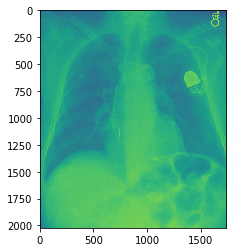

238


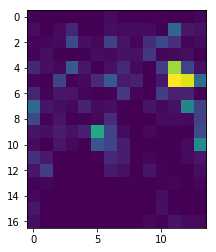

1.1875
1.16474654378


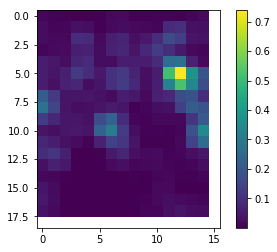

(3056, 2544)


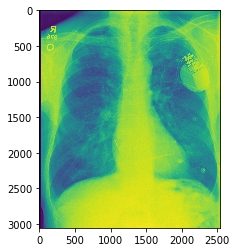

546


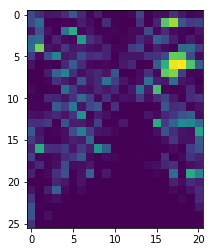

1.21739130435
1.20125786164


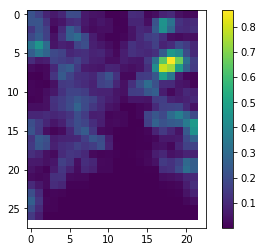

In [200]:
true, false = [], []

for filename in os.listdir(imgspath)[:2]: 
    pixel_arr = plt.imread(os.path.join(imgspath, filename))
    print(pixel_arr.shape)
    plt.imshow(pixel_arr)
    plt.show()
    has_pacemaker(pixel_arr)


In [164]:
17*14

238